### Functions used to convert image to mask

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model

path = "validation_images"
image_list = os.listdir(path)
loaded_image = []
image_size = 1000
current_dir = os.getcwd()

def display_image(image, txt):
    plt.imshow(image, 'gray')
    plt.title(txt, color='black', fontsize=14)
    plt.axis('off')
    plt.show()
    
def black_white (image):
    rectangle = image[30:40, 30:40]
    mean_pixel = np.mean(rectangle)
    if mean_pixel < 100:
        image = np.where(image > 140, 255, image)
        image = np.where(image < 140, 0, image)  
        ret, image = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)
    else :
        image = np.where(image > 80, 255, image)
        image = np.where(image < 100, 0, image) 
    return image

def Placing_black_pixels (image,side):       
    width, height = image.shape[:2]
    pixel_num = 5
    if side == 'right':    
        for h in range(height - 1):
            for w in reversed(range(1, width)):  
                is_white = False
                for i in range(1, pixel_num):   
                    if w - i < 0:
                        break
                    if image[h, w - i] == 255:
                        is_white = True
                        break
                if is_white:
                    image[h, w] = 0
                else:
                    image[h, w] = 0
                    break
    if side == 'left':    
        for h in range(height - 1):
            for w in range(width - 1):
                is_white = False
                for i in range(1, pixel_num ):  
                    if w + i >= width:
                        break
                    if image[h, w + i] == 255:
                        is_white = True
                        break
                if is_white:
                    image[h, w] = 0
                else:
                    image[h, w] = 0
                    break
    return image

def Extraction_of_large_contours (image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    top_contours = contours[:2]
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    cv2.drawContours(image, top_contours, -1, 255, thickness=cv2.FILLED)
    return image

def blurring (image):
    k_size = (int(image_size/20), int(image_size/10))
    image = cv2.blur(image, k_size) 
    return(image)

def manually_threshold (image):
    image = np.where(image > 50, 255, image)
    image = np.where(image < 50, 0, image)
    return(image)

### preprocessing

1/1 [==============================] - 0s 72ms/step


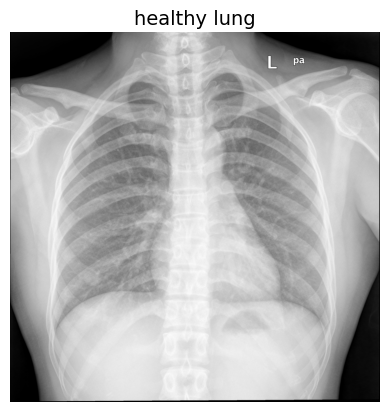

1/1 [==============================] - 0s 15ms/step


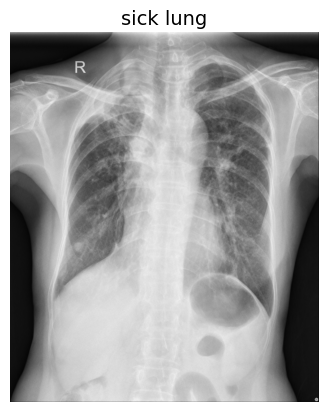

In [2]:
# Load the trained model
classifier = load_model('Lung_Segmentation.h5')

for image_name in image_list:   
    # Preprocessing                          
    image = Image.open(os.path.join(path, image_name))
    raw = image.copy()   
    image = image.resize((image_size, image_size)) 
    image = np.array(image)  
    image = black_white(image)
    image = Placing_black_pixels(image.copy(), 'left') ; image = Placing_black_pixels(image, 'right')
    image = Extraction_of_large_contours(image)
    image = blurring(image)
    image = manually_threshold(image)
    
    # Modeling Part
    image = cv2.resize(image, (128, 128))
    # Expand dimensions to match the batch size
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)  
    
    # Make predictions
    prediction = classifier.predict(image)

    result = np.argmax(prediction)
    
    result = int(result)
    if result == 0:
        pred = "healthy lung"
    if result == 1:
        pred = "sick lung"
    # print(pred)
    display_image(raw,pred)